# Pipeline example, internal outmigration

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

from vivarium import InteractiveContext
from vivarium.framework.configuration import build_simulation_configuration
from vivarium.config_tree import ConfigTree

from vivarium_public_health.population import InternalOutMigration
from vivarium_public_health.population.spenser_population import TestPopulation
from vivarium_public_health.population.spenser_population import transform_rate_table
from vivarium_public_health.population.spenser_population import prepare_dataset

from vivarium_public_health.utilities import read_config_file

## Base plugins for simulation

In [2]:
def base_plugins_simulation():
    config = {'required': {
                  'data': {
                      'controller': 'vivarium_public_health.testing.mock_artifact.MockArtifactManager',
                      'builder_interface': 'vivarium.framework.artifact.ArtifactInterface'
                  }
             }
    }

    return ConfigTree(config)

## Configure a simulation

In [3]:
def config_simulation(inp_file):
    
    if inp_file['prepare_data']['prepare']:
        # read a dataset (normally from daedalus), change columns to be readable by vivarium
        # this function creates a file saved at output_path
        prepare_dataset(
            dataset_path=inp_file['prepare_data']['path_to_dataset'], 
            output_path=inp_file['prepare_data']['path_to_output'],
            lookup_ethnicity=inp_file['prepare_data']['path_to_lookup_ethnicity'],
            columns_map=inp_file['prepare_data']['columns_map'],
            location_code=inp_file['prepare_data']['location_code']
        )
    
    # ============= CONFIGURATION
    if inp_file['configuration']['population']['population_size'] <= 0:
        pop_size = len(pd.read_csv(inp_file['paths']['path_to_pop_file']))
    else:
        pop_size = inp_file['configuration']['population']['population_size']
    
    # config object
    config = build_simulation_configuration()
    config.update({
        'time': {
            'start': inp_file['configuration']['time']['start'],
            'end': inp_file['configuration']['time']['end'],
            'step_size': inp_file['configuration']['time']['step_size']
        },
        'randomness': inp_file['configuration']['randomness'],
        'input_data': inp_file['configuration']['input_data'],
    }, 
        layer='model_override')
    
    config.update({
        'path_to_pop_file': inp_file['paths']['path_to_pop_file'],
        'path_to_internal_outmigration_file': inp_file['paths']['path_to_internal_outmigration_file'],
        
        'population': {
            'population_size': pop_size,
            'age_start': inp_file['configuration']['population']['age_start'],
            'age_end': inp_file['configuration']['population']['age_end'],
        },
        },
    )
    return config

## Create an interactive context manager

In [4]:
inp_file = read_config_file("../config/model_specification_pipeline_006.yaml")

base_plugins = base_plugins_simulation()
config = config_simulation(inp_file=inp_file)
components = [eval(x) for x in inp_file["list_components"]]
simulation = InteractiveContext(components=components,
                                configuration=config,
                                plugin_configuration=base_plugins,
                                setup=False)




Write the dataset at: ../persistant_data/test_ssm_E08000032_MSOA11_ppp_2011.csv


## Internal migration rates

In [5]:
df = pd.read_csv(config.path_to_internal_outmigration_file)
# to save time, only look at locatiosn existing on the test dataset.
df_internal_outmigration = df[(df['LAD.code'] == 'E09000002') | (df['LAD.code'] == 'E09000003')]

asfr_data = transform_rate_table(df_internal_outmigration, 2011, 2012, config.population.age_start,
                                     config.population.age_end)

simulation._data.write("cause.age_specific_internal_outmigration_rate", asfr_data)

## Setup a simulation and run for `num_days`

In [6]:
sim_start = time.time()

simulation.setup()
num_days = 365*1 + 10
simulation.run_for(duration=pd.Timedelta(days=num_days))

sim_end = time.time()

2020-08-10 11:21:14.922 | DEBUG    | vivarium.framework.values:register_value_modifier:373 - Registering metrics.1.population_manager.metrics as modifier to metrics
2020-08-10 11:21:22.198 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline int_outmigration_rate
2020-08-10 11:21:22.199 | DEBUG    | vivarium.framework.values:_register_value_producer:323 - Registering value pipeline metrics


2020-08-10 11:22:04.175 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-01 00:00:00
2020-08-10 11:22:05.576 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-11 00:00:00
2020-08-10 11:22:06.939 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-21 00:00:00
2020-08-10 11:22:08.286 | DEBUG    | vivarium.framework.engine:step:140 - 2011-01-31 00:00:00
2020-08-10 11:22:09.652 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-10 00:00:00
2020-08-10 11:22:10.968 | DEBUG    | vivarium.framework.engine:step:140 - 2011-02-20 00:00:00
2020-08-10 11:22:12.303 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-02 00:00:00
2020-08-10 11:22:13.651 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-12 00:00:00
2020-08-10 11:22:14.981 | DEBUG    | vivarium.framework.engine:step:140 - 2011-03-22 00:00:00
2020-08-10 11:22:16.291 | DEBUG    | vivarium.framework.engine:step:140 - 2011-04-01 00:00:00
2020-08-10 11:22:17.598 | DEBUG    | vivarium.framework.engi

In [7]:
pop = simulation.get_population()
pop.head()

,tracked,last_outmigration_time,internal_outmigration,entrance_time,ethnicity,exit_time,location,sex,alive,age
0,True,NaT,No,2010-12-22,WBI,NaT,E09000002,1,alive,2.041096
1,True,NaT,No,2010-12-22,WBI,NaT,E09000002,1,alive,2.041096
2,True,NaT,No,2010-12-22,WBI,NaT,E09000002,1,alive,2.041096
3,True,NaT,No,2010-12-22,WBI,NaT,E09000002,1,alive,2.041096
4,True,NaT,No,2010-12-22,WBI,NaT,E09000002,1,alive,2.041096


In [8]:
print(f"Total time: {sim_end - sim_start}")
print ('internal outmigration',len(pop[pop['internal_outmigration']=='Yes']))
print ('remaining population',len(pop[pop['internal_outmigration']=='No']))

Total time: 99.7457959651947
internal outmigration 32924
remaining population 489497


In [9]:
migrant_pool = pop[pop['internal_outmigration']=='Yes']

migrant_pool.head()

,tracked,last_outmigration_time,internal_outmigration,entrance_time,ethnicity,exit_time,location,sex,alive,age
12,True,2011-09-08,Yes,2010-12-22,WBI,NaT,E09000002,1,alive,2.041096
30,True,2011-01-11,Yes,2010-12-22,WBI,NaT,E09000002,1,alive,3.041096
41,True,2011-10-28,Yes,2010-12-22,WBI,NaT,E09000002,1,alive,3.041096
54,True,2011-03-22,Yes,2010-12-22,WBI,NaT,E09000002,1,alive,4.041096
83,True,2011-11-27,Yes,2010-12-22,WBI,NaT,E09000002,1,alive,5.041096


## Plot results

In [10]:
#min_time = pop["entrance_time"].min().strftime("%Y-%m-%d")
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2011-12-31", "%Y-%m-%d")

print("min_time:", min_time)
print("max_time:", max_time)

min_time: 2011-01-01
max_time: 2011-12-31 00:00:00


In [11]:
# --- input
# intervals for plotting (in days)
interval_in_days = 10
# list of ethnicities
sel_ethnicity = ["WBI", "WHO"]

# Population (total, for selected ethnicities, gender)
total_population = len(pop)
total_population_ETH = len(pop[pop["ethnicity"].isin(sel_ethnicity)])
total_population_male = len(pop[pop["sex"] == 1])
total_population_female = len(pop[pop["sex"] == 2])

time_axis = []
population_axis = []
population_ETH_axis = []
population_M_axis = []
population_F_axis = []

curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
while curr_time <= max_time:
    time_axis.append(curr_time)
    
    # dead population until current time (changes in the while loop)
    pop_dead = pop[pop["last_outmigration_time"] <= curr_time.strftime("%Y-%m-%d")]
    
    num_dead_population = total_population - len(pop_dead)
    population_axis.append(num_dead_population)
    
    num_dead_population_eth = total_population_ETH - len(pop_dead[pop_dead["ethnicity"].isin(sel_ethnicity)])
    population_ETH_axis.append(num_dead_population_eth)
    
    num_dead_male = total_population_male - len(pop_dead[pop_dead["sex"] == 1])
    population_M_axis.append(num_dead_male)
    
    num_dead_female = total_population_female - len(pop_dead[pop_dead["sex"] == 2])
    population_F_axis.append(num_dead_female)
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

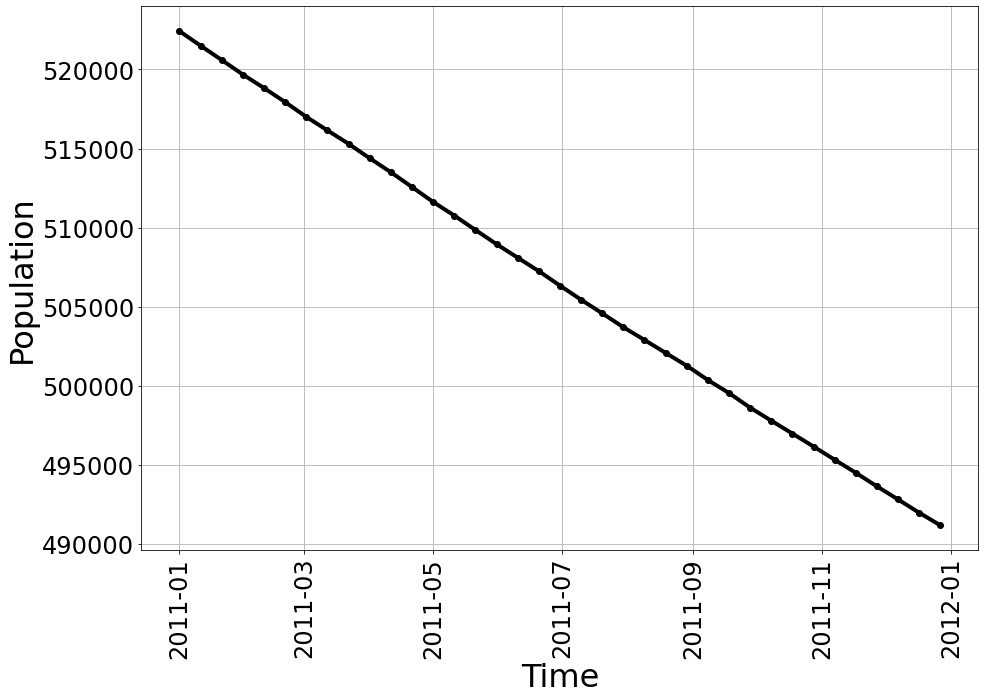

In [13]:
# Population (total)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_axis, 
         c='k', lw=4, marker="o")
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.show()

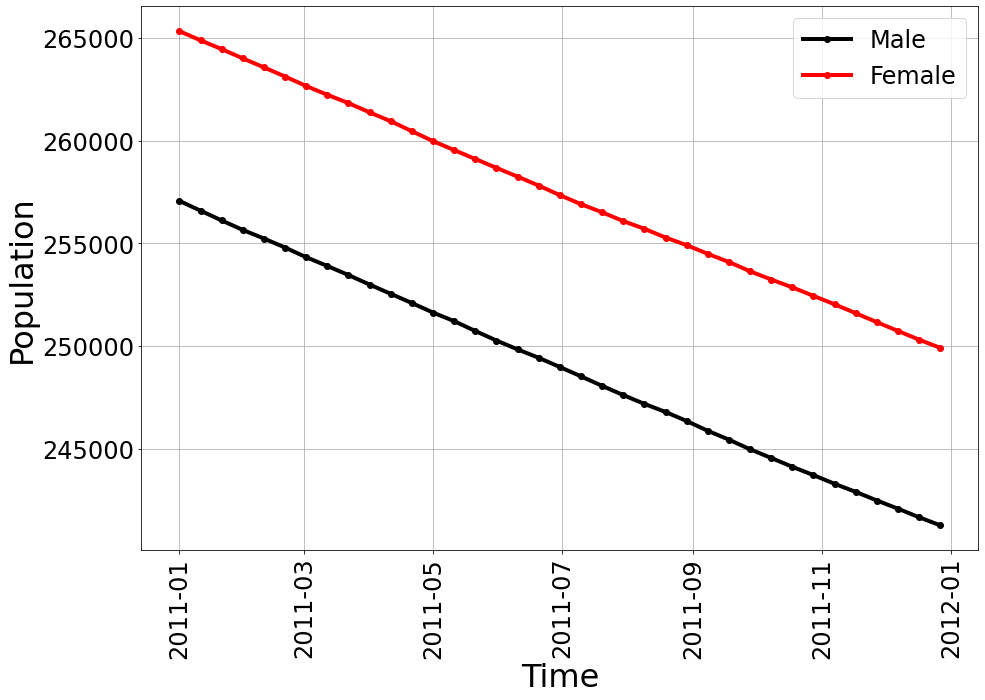

In [14]:
# Population (gender)
plt.figure(figsize=(15, 10))
plt.plot(time_axis, population_M_axis, 
         c='k', lw=4, marker="o", 
         label="Male"
        )
plt.plot(time_axis, population_F_axis, 
         c='r', lw=4, marker="o",
         label="Female"
        )
plt.xlabel("Time", size=32)
plt.ylabel("Population", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
plt.grid()
plt.legend(fontsize=24)
plt.show()

## Histograms

In [15]:
# only migrant population
pop_dead = migrant_pool

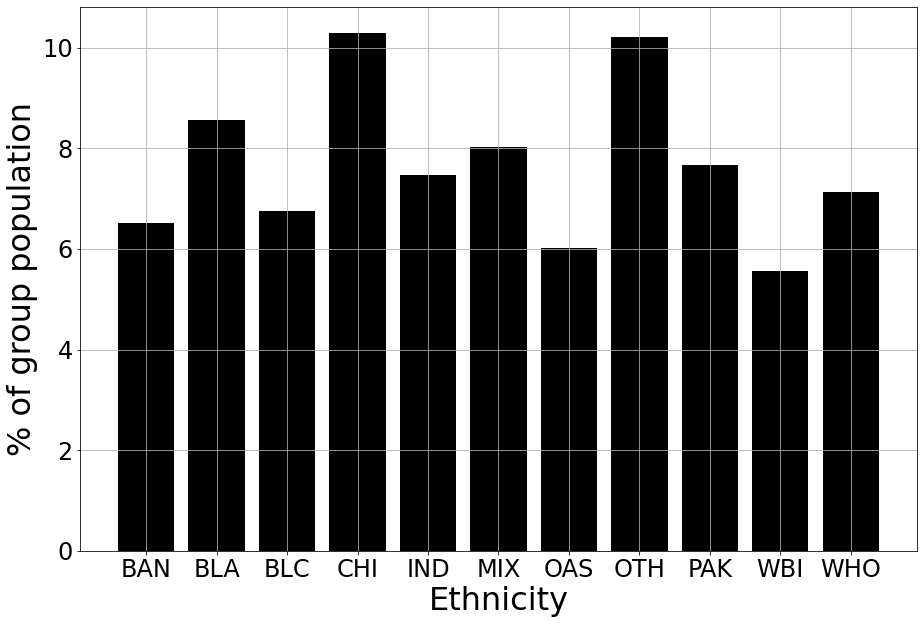

In [16]:
series2plot = migrant_pool['ethnicity'].value_counts() / pop["ethnicity"].value_counts() * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("% of group population", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

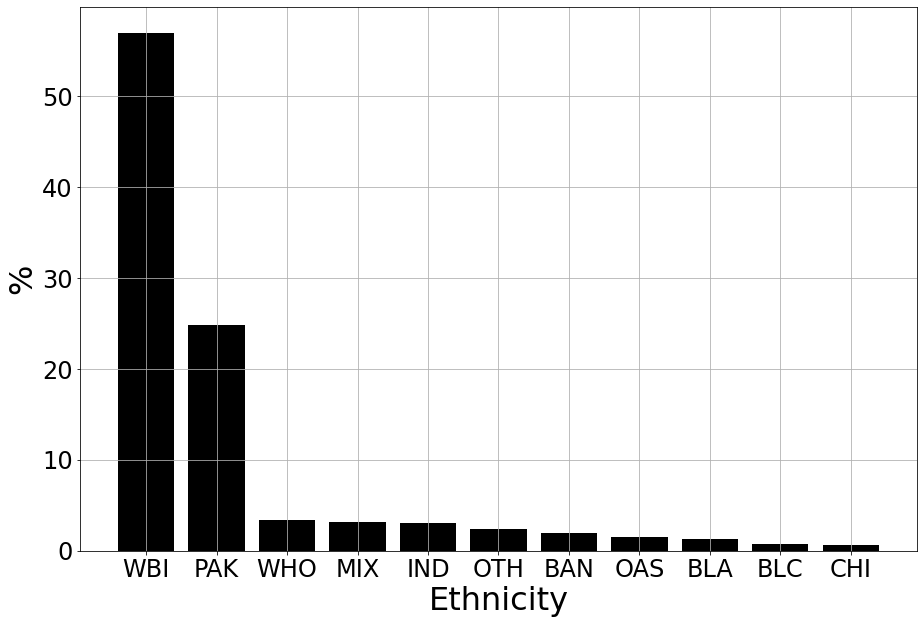

In [17]:
series2plot = migrant_pool['ethnicity'].value_counts() / len(migrant_pool["ethnicity"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Ethnicity", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

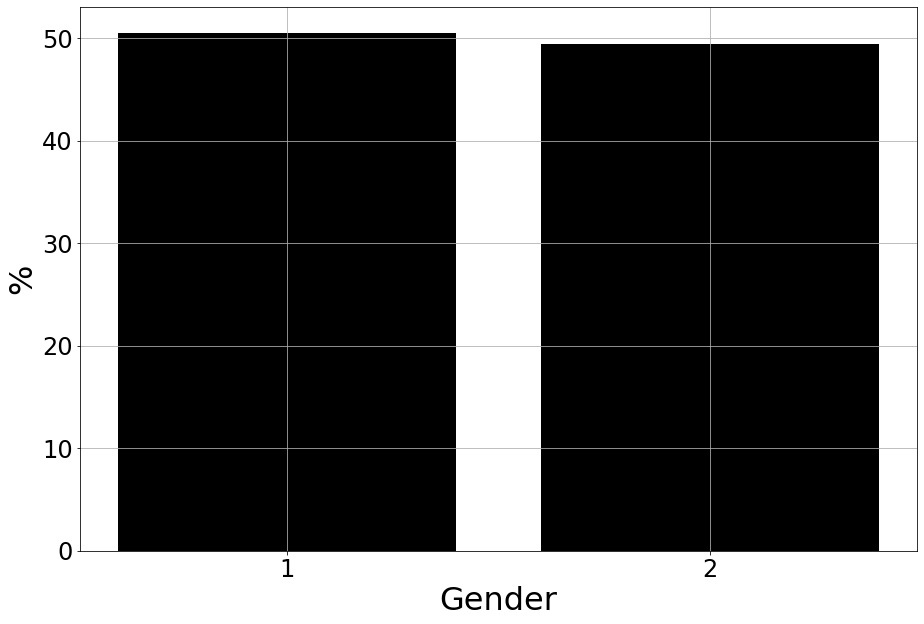

In [18]:
series2plot = migrant_pool['sex'].value_counts() / len(migrant_pool["sex"]) * 100.
indx = range(len(series2plot))

plt.figure(figsize=(15, 10))
plt.bar(indx, series2plot, color='k')

plt.xticks(indx, series2plot.index, size=24)
plt.yticks(size=24)
plt.xlabel("Gender", size=32)
plt.ylabel("%", size=32)

plt.grid()
#plt.legend(fontsize=24)
plt.show()

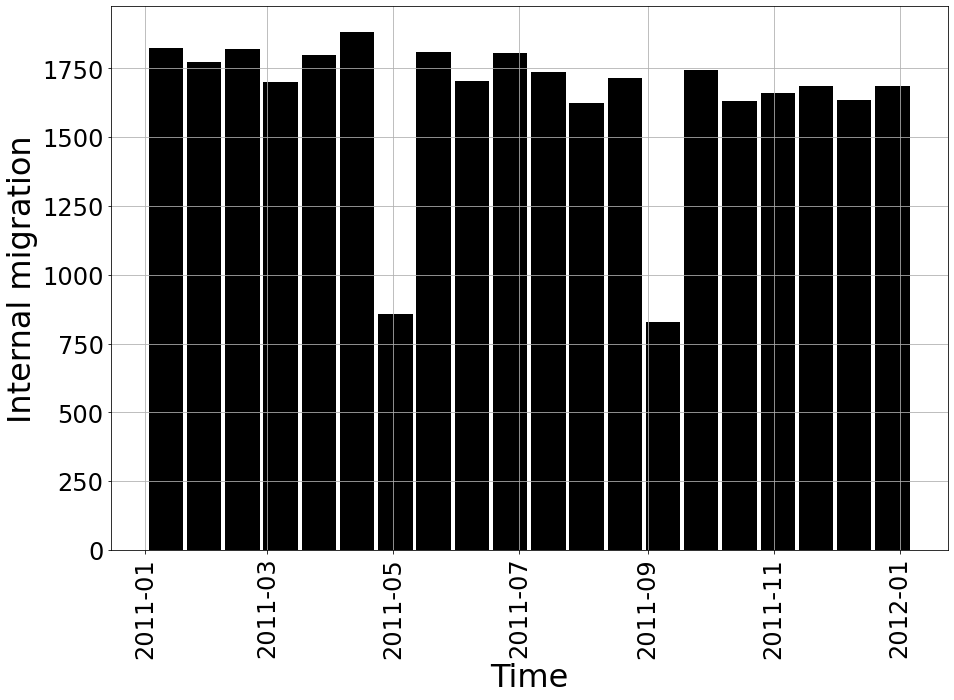

In [19]:
plt.figure(figsize=(15, 10))

pop_dead["last_outmigration_time"].hist(bins=20, 
                           rwidth=0.9, 
                           color='k',
                           align='left'
                          )
plt.xlabel("Time", size=32)
plt.ylabel("Internal migration", size=32)
plt.xticks(size=24, rotation=90)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()

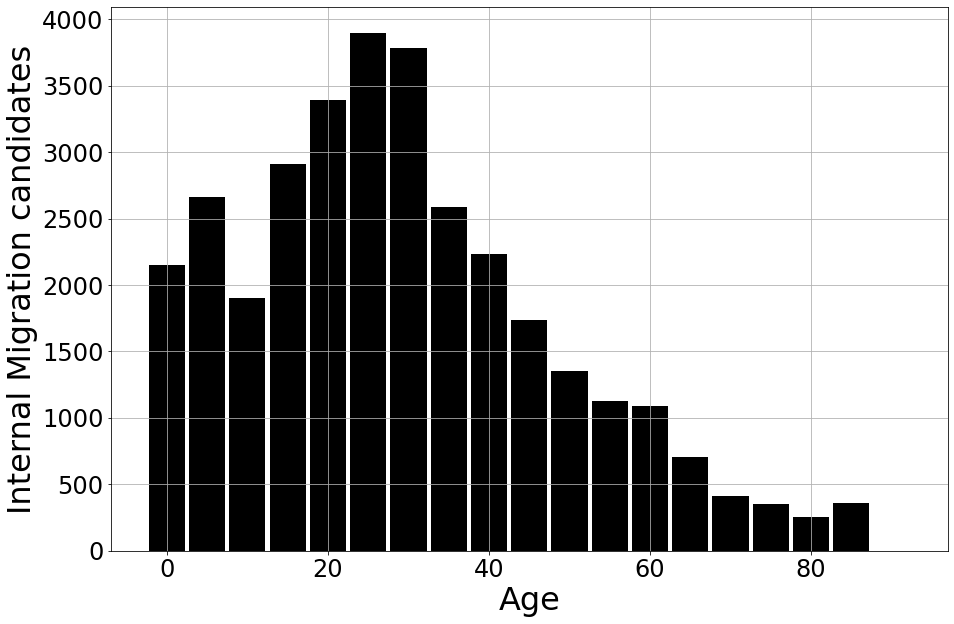

In [20]:
plt.figure(figsize=(15, 10))

migrant_pool["age"].hist(bins=range(0, 100, 5), 
                     rwidth=0.9, 
                     color='k',
                     align='left'
                    )
plt.xlabel("Age", size=32)
plt.ylabel("Internal Migration candidates", size=32)
plt.xticks(size=24)
plt.yticks(size=24)
#plt.legend(fontsize=24)
plt.show()